In [1]:
# Based on https://github.com/ShengjiaZhao/MMD-Variational-Autoencoder/blob/master/mmd_vae.ipynb
import torch
from torch.autograd import Variable

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt
import math, os

In [2]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [3]:
def get_flatten_output():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, 2),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(64, 128, 4, 2),
        torch.nn.LeakyReLU(),
        Flatten(),
    )
    return model(Variable(torch.rand(2,1,28,28))).size()
get_flatten_output()

torch.Size([2, 3200])

In [4]:
def get_reshape_output():
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7*7*128),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(128, 64, 4, 2),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=3),
        torch.nn.Sigmoid()
    )
    return model(Variable(torch.rand(2,2))).size()
get_reshape_output()

torch.Size([2, 1, 28, 28])

In [5]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    

In [6]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [7]:
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [8]:
model = Model(2)

In [9]:
z, x_reconstructed = model(Variable(torch.rand(1,1,28,28)))
z.size(), x_reconstructed.size()

(torch.Size([1, 2]), torch.Size([1, 1, 28, 28]))

In [10]:
# Convert a numpy array of shape [batch_size, height, width, 1] into a displayable array 
# of shape [height*sqrt(batch_size, width*sqrt(batch_size))] by tiling the images
def convert_to_display(samples):
    cnt, height, width = int(math.floor(math.sqrt(samples.shape[0]))), samples.shape[1], samples.shape[2]
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height, cnt, cnt, width])
    samples = np.transpose(samples, axes=[1, 0, 2, 3])
    samples = np.reshape(samples, [height*cnt, width*cnt])
    return samples


def train(
    dataloader,
    z_dim=2,
    n_epochs=10,
    use_cuda=True,
    print_every=100,
    plot_every=500
):
    model = Model(z_dim)
    if use_cuda:
        model = model.cuda()
    #print(model)
    optimizer = torch.optim.Adam(model.parameters())
    i = -1
    for epoch in range(n_epochs):
        for images, labels in dataloader:
            i += 1
            optimizer.zero_grad()
            x = Variable(images, requires_grad=False)
            true_samples = Variable(
                torch.randn(200, z_dim),
                requires_grad=False
            )
            if use_cuda:
                x = x.cuda()
                true_samples = true_samples.cuda()
            z, x_reconstructed = model(x)
            mmd = compute_mmd(true_samples, z)
            nll = (x_reconstructed - x).pow(2).mean()
            loss = nll + mmd
            loss.backward()
            optimizer.step()
            if i % print_every == 0:
                print("Negative log likelihood is {:.5f}, mmd loss is {:.5f}".format(
                    nll.data[0], mmd.data[0]))
            if i % plot_every == 0:
                gen_z = Variable(
                    torch.randn(100, z_dim),
                    requires_grad=False
                )
                if use_cuda:
                    gen_z = gen_z.cuda()
                samples = model.decoder(gen_z)
                samples = samples.permute(0,2,3,1).contiguous().cpu().data.numpy()
                plt.imshow(convert_to_display(samples), cmap='Greys_r')
                plt.show()
                
    return model

## Train on MNIST

In [11]:
batch_size=200
mnist_train = torch.utils.data.DataLoader(
    MNIST("./tmp/MNIST", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=3,
    pin_memory=True
)

Processing...
Done!


Negative log likelihood is 0.23376, mmd loss is 0.15633


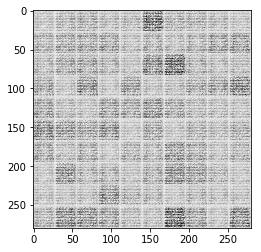

Negative log likelihood is 0.06877, mmd loss is 0.15048
Negative log likelihood is 0.06727, mmd loss is 0.17598
Negative log likelihood is 0.06819, mmd loss is 0.14573
Negative log likelihood is 0.06992, mmd loss is 0.16147
Negative log likelihood is 0.06849, mmd loss is 0.15327


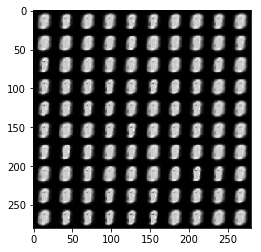

Negative log likelihood is 0.06538, mmd loss is 0.16550
Negative log likelihood is 0.05938, mmd loss is 0.03871
Negative log likelihood is 0.05220, mmd loss is 0.01394
Negative log likelihood is 0.05021, mmd loss is 0.00377
Negative log likelihood is 0.05498, mmd loss is 0.01174


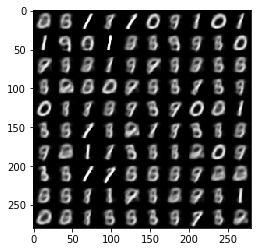

Negative log likelihood is 0.05103, mmd loss is 0.00518
Negative log likelihood is 0.04921, mmd loss is 0.00438
Negative log likelihood is 0.04900, mmd loss is 0.01720
Negative log likelihood is 0.04534, mmd loss is 0.00399
Negative log likelihood is 0.04789, mmd loss is 0.00408


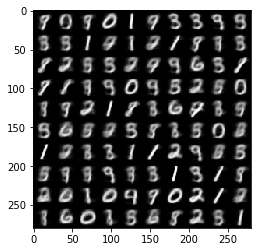

Negative log likelihood is 0.04551, mmd loss is 0.00188
Negative log likelihood is 0.04636, mmd loss is 0.00731
Negative log likelihood is 0.04701, mmd loss is 0.00934
Negative log likelihood is 0.04542, mmd loss is 0.00239
Negative log likelihood is 0.04016, mmd loss is 0.00673


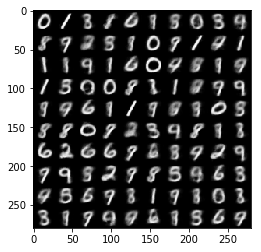

Negative log likelihood is 0.04244, mmd loss is 0.00838
Negative log likelihood is 0.04266, mmd loss is 0.01031
Negative log likelihood is 0.04541, mmd loss is 0.00326
Negative log likelihood is 0.04042, mmd loss is 0.00824
Negative log likelihood is 0.04336, mmd loss is 0.01076


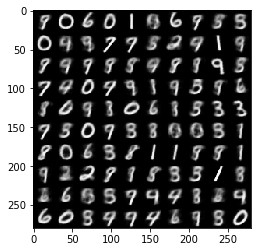

Negative log likelihood is 0.04263, mmd loss is 0.00397
Negative log likelihood is 0.04174, mmd loss is 0.01182
Negative log likelihood is 0.04142, mmd loss is 0.00172
Negative log likelihood is 0.04022, mmd loss is 0.00688


In [12]:
z_dim = 2
model = train(mnist_train, z_dim=z_dim, n_epochs=10)

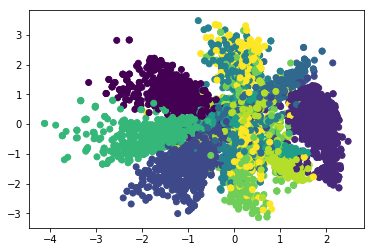

In [13]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        MNIST("./tmp/MNIST", train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(20):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()

## Train on FashionMNIST

Processing...
Done!
Negative log likelihood is 0.17532, mmd loss is 0.15320


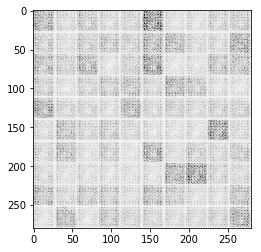

Negative log likelihood is 0.09077, mmd loss is 0.22016
Negative log likelihood is 0.08646, mmd loss is 0.19152
Negative log likelihood is 0.09279, mmd loss is 0.17327
Negative log likelihood is 0.09121, mmd loss is 0.16583
Negative log likelihood is 0.08536, mmd loss is 0.17398


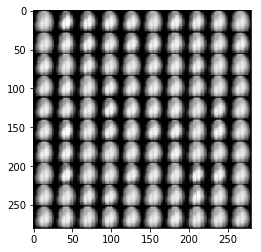

Negative log likelihood is 0.04475, mmd loss is 0.00878
Negative log likelihood is 0.03777, mmd loss is 0.00553
Negative log likelihood is 0.03522, mmd loss is 0.00489
Negative log likelihood is 0.03478, mmd loss is 0.00408
Negative log likelihood is 0.03376, mmd loss is 0.00531


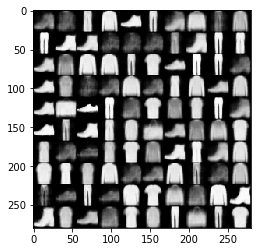

Negative log likelihood is 0.03324, mmd loss is 0.00718
Negative log likelihood is 0.03130, mmd loss is 0.01293
Negative log likelihood is 0.03185, mmd loss is 0.00826
Negative log likelihood is 0.02967, mmd loss is 0.00589
Negative log likelihood is 0.03275, mmd loss is 0.00247


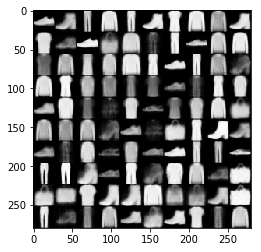

Negative log likelihood is 0.02838, mmd loss is 0.00916
Negative log likelihood is 0.02949, mmd loss is 0.00615
Negative log likelihood is 0.03084, mmd loss is 0.00399
Negative log likelihood is 0.02873, mmd loss is 0.00242
Negative log likelihood is 0.02899, mmd loss is 0.00394


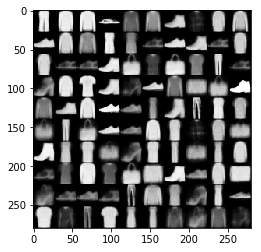

Negative log likelihood is 0.02960, mmd loss is 0.00391
Negative log likelihood is 0.02721, mmd loss is 0.01099
Negative log likelihood is 0.02688, mmd loss is 0.00277
Negative log likelihood is 0.02924, mmd loss is 0.00540
Negative log likelihood is 0.02802, mmd loss is 0.00573


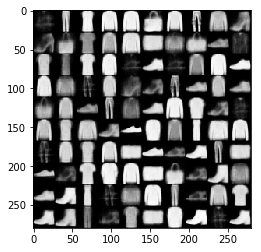

Negative log likelihood is 0.02779, mmd loss is 0.00220
Negative log likelihood is 0.02824, mmd loss is 0.00926
Negative log likelihood is 0.02890, mmd loss is 0.00559
Negative log likelihood is 0.02838, mmd loss is 0.00179


In [15]:
batch_size=200
mnist_train = torch.utils.data.DataLoader(
    FashionMNIST("./tmp/FashionMNIST", train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, num_workers=3,
    pin_memory=True
)


z_dim = 2
model = train(mnist_train, z_dim=z_dim, n_epochs=10)

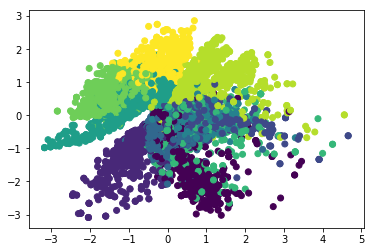

In [16]:
# If latent z is 2-dimensional we visualize it by plotting latent z of different digits in different colors
if z_dim == 2:
    test_batch_size = 500
    mnist_test = torch.utils.data.DataLoader(
        FashionMNIST("./tmp/FashionMNIST", train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=test_batch_size, shuffle=True, num_workers=3,
        pin_memory=True
    )
    z_list, label_list = [], []
    for i in range(20):
        batch_x, batch_y = iter(mnist_test).next()
        batch_x = Variable(batch_x, requires_grad=False).cuda()
        z = model.encoder(batch_x)
        z_list.append(z.cpu().data.numpy())
        label_list.append(batch_y.numpy())
    z = np.concatenate(z_list, axis=0)
    label = np.concatenate(label_list)
    plt.scatter(z[:, 0], z[:, 1], c=label)
    plt.show()